In [1]:
# !pip install powerlaw

In [2]:
import requests
from bs4 import BeautifulSoup
import io
from collections import Counter
import powerlaw
import matplotlib.pyplot as plt

In [4]:
class Post:
    def __init__(self, postnumber, username, location, comment, postdate, reputation, responseto):
        self.postnumber = postnumber
        self.username = username
        self.location = location
        self.comment = comment
        self.postdate = postdate
        self.reputation = reputation
        self.responseto = responseto

def DownloadAllForumMessages(): ## Downloads all the pages on the forum that are related to this thread, takes like a minute to run so only use if you want to update the stored file 
    url = "https://www.city-data.com/forum/health-wellness/3245374-have-you-had-covid-vaccine-side.html"

    RequestedPage = requests.get(url)
    RequestedPageAsText = RequestedPage.text

    soup = BeautifulSoup(RequestedPageAsText, 'html.parser')

    numofpages = int(soup.find(class_="vbmenu_control").text.split()[-1])

    AllPagesText = ""

    for i in range(1, numofpages + 1):
        if i == 1:
            url = "https://www.city-data.com/forum/health-wellness/3245374-have-you-had-covid-vaccine-side.html"
        else:
            url = "https://www.city-data.com/forum/health-wellness/3245374-have-you-had-covid-vaccine-side-".strip() + str(i).strip() + ".html".strip()
        RequestedPage = requests.get(url)
        RequestedPageAsText = RequestedPage.text
        AllPagesText += RequestedPageAsText
    with io.open("ForumContent.txt", "w", encoding="utf-8") as f:
        f.write(AllPagesText)

In [6]:
with io.open("ForumContent.txt", "r", encoding="utf-8") as f:
    Text = f.read()
soup = BeautifulSoup(Text, 'html.parser')
posts = soup.find_all(id= lambda x: x and x.startswith("post60"))
index = 1
ListOfPosts = []
ListOfLocations = []
for i in posts:
    responseto = []
    postnumber = index
    index += 1
    location = i.find(text= lambda x: x and x.startswith("Location: "))
    username = i.find(class_="bigusername").text
    comment = i.find(id= lambda x: x and x.startswith("post_message_")).text
    responses = i.find_all("strong")
    ListOfLocations.append(location)
    for j in responses:
        responseto.append(j.get_text())	
    postdate = i.find(class_="thead").text.strip()
    reputation = i.find(class_="smallfont").text.strip().replace("\n", " ").replace("\t", "")
    ListOfPosts.append(Post(postnumber, username, location, comment, postdate, reputation, responseto))

for i in ListOfPosts[:5]:
    print("\n\n", i.postnumber, i.username, i.location, i.postdate, i.reputation, "Response to:", i.responseto, "\n")



 1 mascoma None 02-13-2021, 06:10 PM 4,259 posts, read 1,161,437 times   Reputation: 4418 Response to: [] 



 2 Lillie767 Location: USA 02-13-2021, 06:54 PM Location: USA   2,335 posts, read 896,592 times   Reputation: 6612 Response to: [] 



 3 mascoma None 02-13-2021, 07:01 PM 4,259 posts, read 1,161,437 times   Reputation: 4418 Response to: ['Lillie767'] 



 4 TravelingBoat Location: Los Angeles 02-13-2021, 11:51 PM Location: Los Angeles   421 posts, read 208,469 times   Reputation: 847 Response to: [] 



 5 Lola The yorkie None 02-14-2021, 12:55 AM 984 posts, read 457,918 times   Reputation: 1259 Response to: ['Lillie767'] 



Data Statistics

In [7]:
reads, comments, users, locs = [], [], [], []
for i in ListOfPosts:
    curr = i.reputation
    start = curr.find('read ') + 5
    end = curr.find(' times')
    reads.append( curr[start:end].replace(',', ''))
    comments.append(i.comment)
    users.append(i.username)
    locs.append(i.location)

In [8]:
import numpy as np
locs = [i for i in locs if i]
uni_locs = np.unique( locs )
print('Unique locations: ', len(uni_locs))

uni_users = np.unique( users )
print('Unique Users: ', len(uni_users))

reads = [int(read) for read in reads if read.isnumeric()]
print('Sum of all reads', sum(reads))

Unique locations:  93
Unique Users:  182
Sum of all reads 3252118296


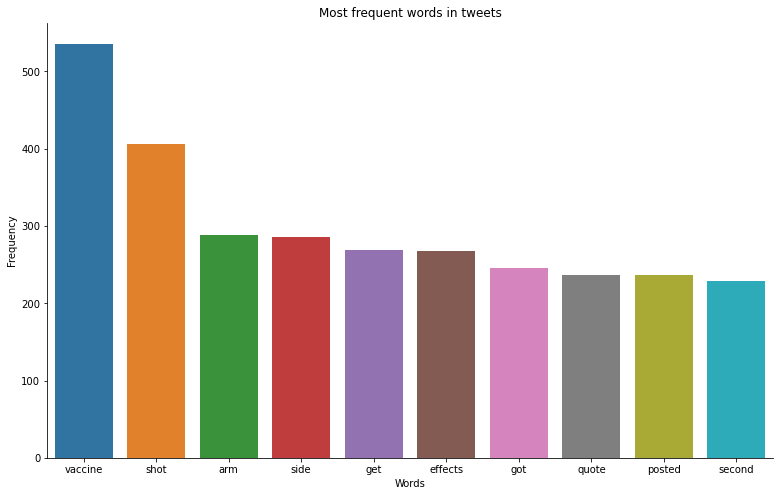

In [10]:
import pandas as pd
import nltk
import seaborn as sns
from nltk.corpus import stopwords
# nltk.download('stopwords')
stopwords = stopwords.words('english')

# nltk.download('punkt')

all_words = []
for comment in comments:
    sent_text = nltk.sent_tokenize(comment)
    words = [word.lower() for sent in sent_text for word in nltk.word_tokenize(sent) if word.isalpha()]
    words  = [word for word in words if not word in stopwords]
    all_words.extend(words)


# tokens = [word for sentence in df['post_processed'] for word in sentence.split(' ') if len(word)>1]
frequency = nltk.FreqDist(all_words)
freq_data = pd.DataFrame({'Words': list(frequency.keys()),
                  'Count': list(frequency.values())})

plt.figure(figsize=(13,8))
sns.barplot(data=freq_data.nlargest(columns='Count', n=10), x='Words', y='Count')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Most frequent words in tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.savefig('frequent.png')
plt.show()